In [1]:
import numpy as np
import pandas as pd
import yaml
import torch
from copy import deepcopy
import matplotlib.pyplot as plt
from celldreamer.eval.eval_utils import normalize_and_compute_metrics
import scipy.sparse as sp

from torch import nn
import scanpy as sc    

from celldreamer.data.scrnaseq_loader import RNAseqLoader
from celldreamer.models.featurizers.category_featurizer import CategoricalFeaturizer
from celldreamer.models.fm.fm import FM
from celldreamer.eval.optimal_transport import wasserstein
import random
from celldreamer.models.base.encoder_model import EncoderModel
from celldreamer.models.base.utils import unsqueeze_right

from celldreamer.paths import DATA_DIR
from tqdm import tqdm

import time
device  = "cuda" if torch.cuda.is_available() else "cpu"

sc.settings.figdir = 'figures'  # Directory to save figures
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(6, 6)) 

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Step 1: Initialize data

In [2]:
dataset_config = {'dataset_path': DATA_DIR / 'processed_full_genome' / 'dentategyrus' / 'dentategyrus_train.h5ad',
                    'layer_key': 'X_counts',
                    'covariate_keys': ['clusters'],
                    'conditioning_covariate': 'clusters',
                    'subsample_frac': 1,
                    'encoder_type': 'learnt_autoencoder',
                    'target_max': 1,
                    'target_min': -1,
                    'one_hot_encode_features': False,
                    'split_rates': [0.90, 0.10],
                    'cov_embedding_dimensions': 256}

data_path = dataset_config["dataset_path"]

dataset = RNAseqLoader(data_path=data_path,
                                layer_key=dataset_config["layer_key"],
                                covariate_keys=dataset_config["covariate_keys"],
                                subsample_frac=dataset_config["subsample_frac"], 
                                encoder_type=dataset_config["encoder_type"])

in_dim = dataset.X.shape[1]
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}
n_cat = len(dataset.id2cov["clusters"])

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


## Step 2: Initialize encoder

In [3]:
encoder_config = {
    "x0_from_x_kwargs": {
        "dims": [512, 256, 50],
        "batch_norm": True,
        "dropout": False,
        "dropout_p": 0.0
    },
    "learning_rate": 0.001,
    "weight_decay": 0.00001,
    "covariate_specific_theta": False
}

state_dict_path = "/home/icb/alessandro.palma/environment/cfgen/project_folder/experiments/off_train_autoencoder_dentategyrus_whole_genome/feab789d-5b04-45c4-b26a-cbaf0d44755a/checkpoints/epoch_59.ckpt"

In [4]:
encoder_model = EncoderModel(in_dim=in_dim,
                              n_cat=n_cat,
                              conditioning_covariate=dataset_config["conditioning_covariate"], 
                              encoder_type=dataset_config["encoder_type"],
                              **encoder_config)

encoder_model.eval()

encoder_model.load_state_dict(torch.load(state_dict_path)["state_dict"])

<All keys matched successfully>

## Step 3: Initialize FM model

In [5]:
generative_model_config = {'learning_rate': 0.0001,
                            'weight_decay': 0.00001,
                            'antithetic_time_sampling': True,
                            'sigma': 0.5
                        }

In [6]:
ckpt = torch.load("/home/icb/alessandro.palma/environment/cfgen/project_folder/experiments/off_fm_resnet_autoencoder_dentategyrus_whole_genome_no_size_factor/e211fcc1-6bbc-4e23-959f-7f0faf43c3c0/checkpoints/last.ckpt")

denoising_model = ckpt["hyper_parameters"]["denoising_model"]
denoising_model.multimodal = False

## 

In [7]:
print(ckpt["hyper_parameters"]["feature_embeddings"]["clusters"].embeddings.weight)
feature_embeddings = ckpt["hyper_parameters"]["feature_embeddings"]

Parameter containing:
tensor([[ 1.6060, -0.2317, -0.7704,  ..., -0.9186, -0.1698, -0.5117],
        [ 0.7627,  0.4520, -1.5396,  ...,  0.9735,  0.4341, -0.1543],
        [ 0.4831, -0.8131, -0.8851,  ...,  1.1645, -0.2730, -0.0420],
        ...,
        [-0.7464, -0.5494,  2.0874,  ..., -0.7229,  2.7816,  1.5183],
        [ 0.2337, -0.5122, -0.7488,  ..., -0.9211, -0.2898,  1.3669],
        [-0.3027,  1.0182, -0.5149,  ..., -0.1470,  0.4659, -1.0136]],
       device='cuda:0', requires_grad=True)


Initializations

In [8]:
generative_model = FM(
            encoder_model=encoder_model,
            denoising_model=denoising_model,
            feature_embeddings=feature_embeddings,
            plotting_folder=None,
            in_dim=50,
            size_factor_statistics=size_factor_statistics,
            encoder_type=dataset_config["encoder_type"],
            conditioning_covariate=dataset_config["conditioning_covariate"],
            model_type=denoising_model.model_type, 
            **generative_model_config  # model_kwargs should contain the rest of the arguments
            )

generative_model.load_state_dict(ckpt["state_dict"])
generative_model.to("cuda")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'encoder_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_model'])`.
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


FM(
  (encoder_model): EncoderModel(
    (x0_from_x): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=17002, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=512, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (2): Linear(in_features=256, out_features=50, bias=True)
      )
    )
    (x_from_x0): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=50, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
         

# Save three copies of generated datasest 

In [9]:
adata_original = sc.read_h5ad(DATA_DIR / 'processed_full_genome' / 'dentategyrus' / 'dentategyrus_test.h5ad')
adata_original.X = adata_original.layers["X_counts"].copy()
adata_original.obs["size_factor"]=adata_original.X.A.sum(1)
saving_dir = DATA_DIR / "generated" / "dentategyrus"

In [10]:
adata_original

AnnData object with n_obs × n_vars = 3643 × 17002
    obs: 'Age', 'clusters', 'size_factor'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'clusters_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'X_counts', 'ambiguous', 'matrix', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [30]:
index_range = len(adata_original)
num_indices = 100
times = []

for it in tqdm(range(3)):
    # X_generated_list = []
    # classes_str = []

    t0 = time.time()
    # Look
    # for _ in range(36):
        
    #     # Generate random dummy indices without replacement
    #     indices = random.sample(range(index_range), num_indices)
    #     adata_indices = adata_original[indices]
        
    #     classes =  list(adata_indices.obs.clusters)
    #     classes_str += classes
    #     classes = torch.tensor([dataset.id2cov["clusters"][c] for  c in classes])
        
    #     X_generated = generative_model.batched_sample(batch_size=10,
    #                                                     repetitions=10,
    #                                                     n_sample_steps=2, 
    #                                                     covariate="clusters", 
    #                                                     covariate_indices=classes, 
    #                                                     log_size_factor=None)
    
    #     X_generated_list.append(X_generated.to("cpu"))

    # No loop
    classes_str =  list(adata_original.obs["clusters"])
    classes = torch.tensor([dataset.id2cov["clusters"][c] for  c in classes_str])[:3600]
    X_generated = generative_model.sample(batch_size=3600,
                                            n_sample_steps=2, 
                                            covariate="clusters", 
                                            covariate_indices=classes, 
                                            log_size_factor=None)
    
    t1 = time.time()
    times.append(t1-t0)
    X_generated = X_generated.to("cpu")
    

    # X_generated_list = torch.cat(X_generated_list, dim=0)
    
    # adata_generated = sc.AnnData(X=sp.csr_matrix(deepcopy(X_generated_list).cpu().numpy()))
    # adata_generated.obs["size_factor"] = adata_generated.X.sum(1)
    # adata_generated.obs["clusters"] = classes_str
    # adata_generated.obs["clusters"] = adata_generated.obs["clusters"].astype("category")
    # adata_generated.layers["X_counts"] = adata_generated.X.copy()
    # sc.pp.normalize_total(adata_generated, target_sum=10000)
    # sc.pp.log1p(adata_generated)
    # sc.tl.pca(adata_generated)
    # adata_generated.write_h5ad(f"/home/icb/alessandro.palma/environment/celldreamer/project_folder/datasets/generated/dentategyrus/generated_cells_{it}.h5ad")

100%|██████████| 3/3 [00:01<00:00,  2.98it/s]


In [31]:
print(np.mean(times))

0.25794219970703125


In [32]:
print(np.std(times)/np.sqrt(3))

0.010923708504193323


Plot results

In [22]:
joint_adata = sc.AnnData(X=np.concatenate([adata_original.layers["X_counts"].A, X_generated], axis=0), 
                        obs={"dataset_type": ["real" for _ in range(adata_original.shape[0])] + ["generated" for _ in range(X_generated.shape[0])]})

In [23]:
sc.pp.normalize_total(joint_adata, target_sum=1e4)

In [24]:
sc.pp.log1p(joint_adata)

In [25]:
sc.tl.pca(joint_adata)
sc.pp.neighbors(joint_adata)
sc.tl.umap(joint_adata)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


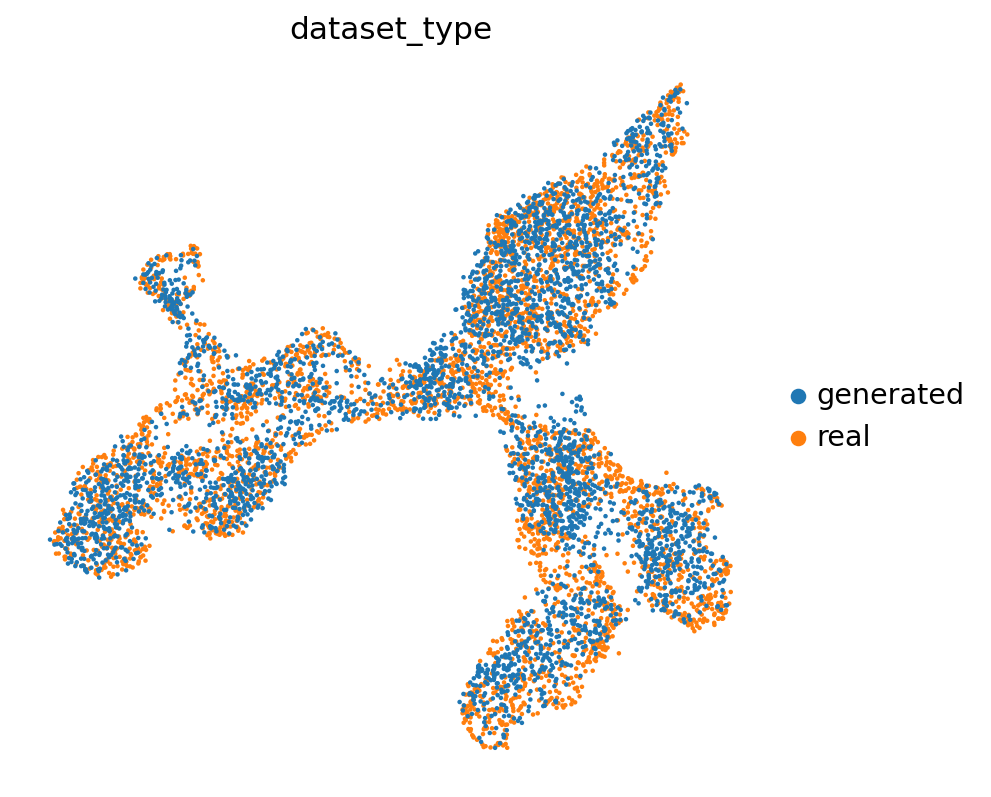

In [26]:
sc.pl.umap(joint_adata, color="dataset_type")